In [1]:
import sys
# SITE_PACKAGES_PATH = '/home/rpartsey/miniconda3/envs/benchbot/lib/python3.8/site-packages'
# if SITE_PACKAGES_PATH not in sys.path:
#     sys.path.insert(0, SITE_PACKAGES_PATH)
PROJECT_ROOT = '../..'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)  # add project roo dir to the path

import os
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint, pformat
from scipy.spatial.transform import Rotation as Rot

from utils.common.utils import (
    compute_fov,
    polar_to_cart,
    local_to_global,
    compute_normals,
    fov_bounds,
    compute_intersection,
    rotation_matrix
)

from utils.vis.utils import (
    ObservationVisualiser, 
    _vis_depth, 
    _vis_laser, 
    _vis_rgb,  
    _vis_poses, 
    _set_axes_equal,
    plot_fov_bounds,
    plot_scan,
    plot_normals
)

from utils.nav.mapping import Map

%matplotlib inline

In [2]:
scenes = [
    'miniroom_1_observations.p',
    'miniroom_1_nav_policy_observations.p',
    'house_1_observations.p',
    'house_1_nav_policy_observations.p'
]
scene_id = 1
observations_path = f'../../data/{scenes[scene_id]}'

In [3]:
with open(observations_path, 'rb') as f:
    observations_data = pickle.load(f)
    
observations = observations_data['observations']

### Compute Camera FOV

In [4]:
obs = observations[0]

camera_info = obs['image_rgb_info']
# camera_info = obs['image_depth_info']
print('Camera info:\n', pformat(camera_info),'\n')
matrix_intrinsics = camera_info['matrix_intrinsics']

w = camera_info['width']
h = camera_info['height']
fx = matrix_intrinsics[0, 0]
fy = matrix_intrinsics[1, 1]

fov_x_rad = compute_fov(w, fx)
fov_y_rad = compute_fov(h, fy)

fov_x = np.rad2deg(fov_x_rad)
fov_y = np.rad2deg(fov_y_rad)

print("Field of View (degrees):")
print(f"  {fov_x = :.1f}\N{DEGREE SIGN}")
print(f"  {fov_y = :.1f}\N{DEGREE SIGN}")

Camera info:
 {'frame_id': 'carter_camera_stereo_left',
 'height': 720,
 'matrix_intrinsics': array([[671.91601562,   0.        , 640.        ],
       [  0.        , 672.94030762, 360.        ],
       [  0.        ,   0.        ,   1.        ]]),
 'matrix_projection': array([[671.91601562,   0.        , 640.        ,   0.        ],
       [  0.        , 672.94030762, 360.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]]),
 'width': 1280} 

Field of View (degrees):
  fov_x = 87.2°
  fov_y = 56.3°


In [5]:
def compute_next_pose(observations, first_step=True, plot=True):
    obs = observations
    
    poses = copy.deepcopy(obs['poses'])
    lidar = poses['lidar']
    origin = lidar['translation_xyz']
    orientation = lidar['rotation_rpy']

    scan_points_polar = obs['laser']['scans']
    scan_points_polar = np.array([x for x in scan_points_polar if x[0] < 10]) # remove outliers

    scan_points = polar_to_cart(scan_points_polar)
    scan_points = np.concatenate(
        (
            scan_points,
            np.zeros((scan_points.shape[0], 1))
        ),
        axis=1
    )

    scan_points_rot_trans = local_to_global(origin, orientation, scan_points) 
    # scan_points_rot_trans = scan_points

#     z_norm = compute_normals(scan_points_rot_trans, scale_by_x=True)
    z_norm = compute_normals(scan_points_rot_trans, scale_by_x=False)

#     scan_points_flip = np.flip(np.copy(scan_points_rot_trans), axis=0)
#     z_norm_flip = compute_normals(scan_points_rot_trans, scale_by_x=True)
#     z_norm_2 = np.flip(z_norm_flip, axis=0)

#     z_norm -= z_norm_2
#     z_norm /= 2
    
#     z_norm = z_norm_2
    
    origin_local = np.array([0, 0])
    
    if plot:
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(121)
    
        plot_scan(ax, scan_points_rot_trans, c='k', s=4, marker='s')
        plot_normals(ax, scan_points_rot_trans, z_norm / np.linalg.norm(z_norm, axis=1).reshape((z_norm.shape[0], 1)))
    
        hfov_bounds = fov_bounds(fov_x_rad)
        rot_obj = Rot.from_euler('xyz', orientation)
        hfov_bounds_rot = np.array([rot_obj.apply(p) for p in hfov_bounds])
        plot_fov_bounds(ax, origin, hfov_bounds_rot)
    
    # camera_rot = obs['poses']['camera']['rotation_rpy'][:2]
    # ax.arrow(origin[0], origin[1], camera_rot[0], camera_rot[1], alpha=0.4, color='r')
    # camera_rot = np.array([1, 0])
    # ax.arrow(0, 0, camera_rot[0], camera_rot[1], alpha=0.4, color='r')
    # plot_fov_bounds(ax, origin_local, hfov_bounds)
    
    shift = 0 if first_step else -fov_x_rad / 3
    
    phi = np.copy(scan_points_polar[:, 1])
    phi_forward = (phi > shift-fov_x_rad/2) & (phi < shift+fov_x_rad/2) 
    
    if plot:
        plot_scan(ax, scan_points_rot_trans[phi_forward], c='r', s=4, marker='s')

    delta_phi = (fov_x_rad / 3) / 2
    delta_phi_forward = (phi > shift-delta_phi) & (phi < shift+delta_phi)
    
    if plot:
        plot_scan(ax, scan_points_rot_trans[delta_phi_forward], c='violet', s=4, marker='s')

    indices, = np.where(phi_forward)
    indices = sorted(indices)

    scalar = 4
    avg_norm = scalar * -np.average(z_norm[phi_forward], axis=0)

    theta = fov_x_rad / 3 / 2
    avg_norm_left = rotation_matrix(-theta) @ avg_norm[:2]
    avg_norm_right = rotation_matrix(theta) @ avg_norm[:2]

    indices, = np.where(delta_phi_forward)
    origin_left = scan_points_rot_trans[indices[phi[delta_phi_forward].argmin()]]
    origin_right = scan_points_rot_trans[indices[phi[delta_phi_forward].argmax()]]
    
    if plot:
        ax.arrow(origin_left[0], origin_left[1], avg_norm_left[0], avg_norm_left[1], alpha=0.4, color='g')
        ax.arrow(origin_right[0], origin_right[1], avg_norm_right[0], avg_norm_right[1], alpha=0.4, color='b')

    intersection = compute_intersection(origin_left, avg_norm_left, origin_right, avg_norm_right)
    
    if plot:
        ax.scatter(*intersection, c='r', s=4)
        ax.arrow(intersection[0], intersection[1], -avg_norm[0], -avg_norm[1], alpha=0.4, color='r')
        # ax.arrow(origin_local[0], origin_local[1], intersection[0], intersection[1], alpha=0.4, color='r')
    
        ax = fig.add_subplot(122)
        _vis_rgb(ax, obs['image_rgb'])
        plt.show()

    return np.array(intersection), -avg_norm


### Boundary Coverage Based  Navigation

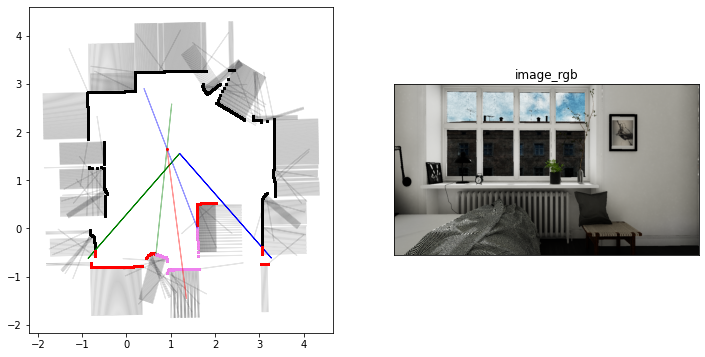

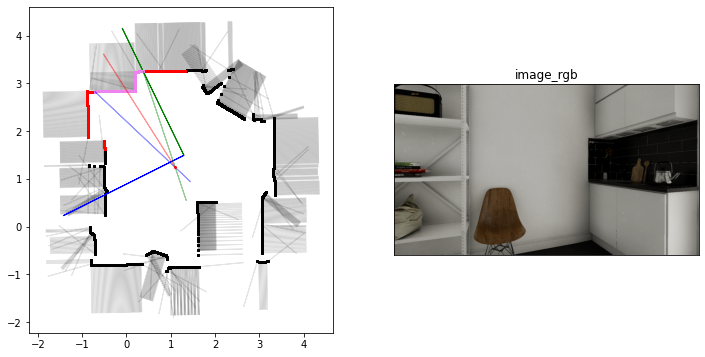

In [6]:
for i, obs in enumerate(observations[:2]):
    next_position, next_orientation = compute_next_pose(obs, first_step=i==0, plot=True)#i % 3 == 0)

### Mapping

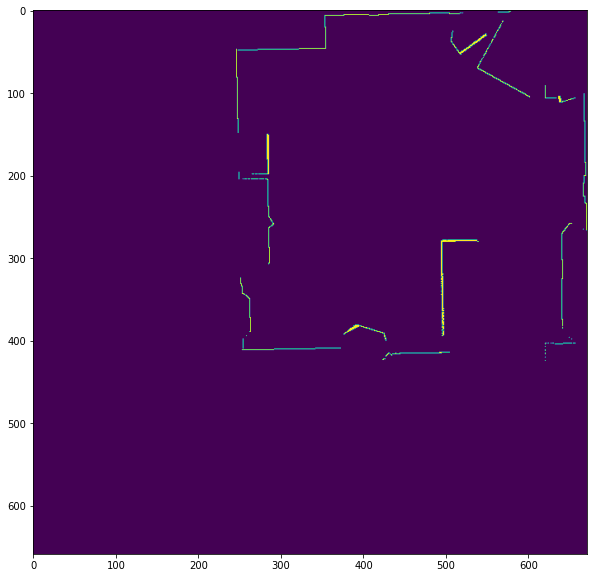

In [7]:
miniroom_map = Map(scale=0.01)

for obs in observations[:]:
    poses = copy.deepcopy(obs['poses'])
    lidar = poses['lidar']
    origin = lidar['translation_xyz']
    orientation = lidar['rotation_rpy']

    scan_points_polar = obs['laser']['scans']
    scan_points_polar = np.array([x for x in scan_points_polar if x[0] < 10]) # remove outliers

    scan_points = polar_to_cart(scan_points_polar)
    scan_points = np.concatenate(
        (
            scan_points,
            np.zeros((scan_points.shape[0], 1))
        ),
        axis=1
    )

    scan_points_rot_trans = local_to_global(origin, orientation, scan_points) 
    
    miniroom_map.update(scan_points_rot_trans)
    
plt.figure(figsize=(10,10))
plt.imshow(miniroom_map.map>0)
plt.show()

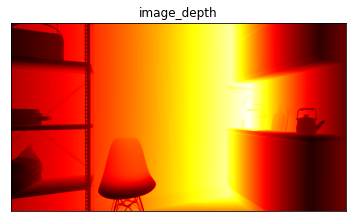

In [8]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

_vis_depth(ax, observations[1]['image_depth'])

plt.show()